Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10
135/135 [==============================] - 1259s 9s/step - loss: 1.8933 - accuracy: 0.2065 - val_loss: 1.6101 - val_accuracy: 0.1951
Epoch 2/10
135/135 [==============================] - 829s 6s/step - loss: 1.6032 - accuracy: 0.2181 - val_loss: 1.6110 - val_accuracy: 0.1941
Epoch 3/10
135/135 [==============================] - 830s 6s/step - loss: 1.6014 - accuracy: 0.2206 - val_loss: 1.6244 - val_accuracy: 0.2074
Epoch 4/10
135/135 [==============================] - 833s 6s/step - loss: 1.6001 - accuracy: 0.2348 - val_loss: 1.6178 - val_accuracy: 0.1932
Epoch 5/10
135/135 [==============================] - 823s 6s/step - loss: 1.5778 - accuracy: 0.2649 - val_loss: 1.6242 - val_accuracy: 0.2027
Epoch 6/10
135/135 [==============================] - 825s 6s/step - loss: 1.5723 - accuracy: 0.2885 - val_loss: 1.6499 - val_accuracy: 0.2112
Epoch 7/10
1

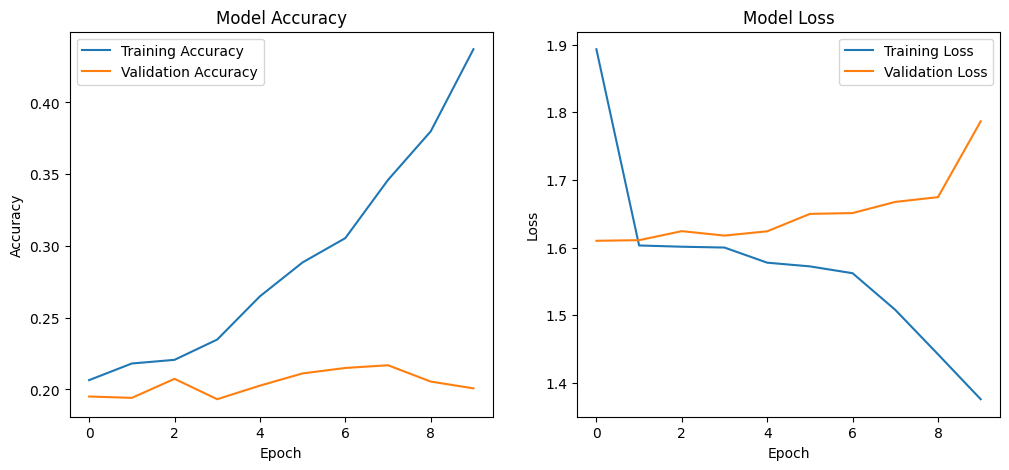

1/1 [==============================] - 0s 474ms/step


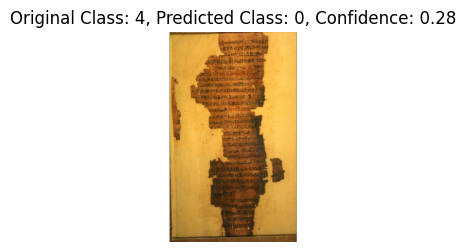

In [ ]:
import os
import numpy as np
import random
from PIL import Image, ImageOps
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

# Connect Google Colab with Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Directory containing the dataset
data_dir = '/content/drive/My Drive/totalall/'

# Get all image paths in the directory
images_paths = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith(('.jpg', '.png', '.jpeg'))]

# Define target size
target_size = (256, 256)

# Function to process images
def process_image(image_path):
    try:
        image_path = image_path.numpy().decode('utf-8')  # Decode the EagerTensor to string
        img = Image.open(image_path).convert('RGB')  # Convert image to RGB
        img = ImageOps.fit(img, target_size, method=Image.LANCZOS)  # Center crop and resize
        img = ImageOps.pad(img, target_size, method=Image.NEAREST, centering=(0.5, 0.5))  # Center the image with padding
        img = np.array(img) / 255.0  # Normalize the image
        if img.shape != (256, 256, 3):
            raise ValueError(f"Unexpected image shape: {img.shape}")
        return img
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return np.zeros((256, 256, 3))  # Replace the failed image with an empty array of the same size

# Function to load and process image for TensorFlow dataset
def load_and_preprocess_image(path, label):
    img = tf.py_function(process_image, [path], [tf.float32])
    img = tf.reshape(img, (256, 256, 3))
    return img, label

# Fake labels (you can replace them with your actual labels)
def generate_labels(num_images):
    return np.random.randint(0, 5, size=(num_images,))  # Replace with your actual labels

# Set up data
batch_size = 32  # Batch size
train_size = int(0.8 * len(images_paths))
train_paths = images_paths[:train_size]
test_paths = images_paths[train_size:]

# Create datasets using tf.data.Dataset
train_labels = generate_labels(len(train_paths))
test_labels = generate_labels(len(test_paths))

train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

# Apply the load and preprocess function to the datasets
train_dataset = train_dataset.map(load_and_preprocess_image).batch(batch_size).repeat()
test_dataset = test_dataset.map(load_and_preprocess_image).batch(batch_size).repeat()

# Build image classification model
classification_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')  # Number of classes
])

# Compile the model
classification_model.compile(optimizer='adam',
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

# Calculate the number of batches for each dataset
train_steps_per_epoch = len(train_paths) // batch_size
test_steps_per_epoch = len(test_paths) // batch_size

# Train the model
history = classification_model.fit(
    train_dataset,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=test_dataset,
    validation_steps=test_steps_per_epoch
)

# Evaluate the model
test_loss, test_acc = classification_model.evaluate(
    test_dataset,
    steps=test_steps_per_epoch,
    verbose=2
)
print(f'\nTest accuracy: {test_acc}')

# Display the outputs as graphs
plt.figure(figsize=(12, 5))

# Plot training and test accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Random image prediction step
# Randomly select an image path from the test dataset
random_index = random.randint(0, len(test_paths) - 1)
random_image_path = test_paths[random_index]
random_label = test_labels[random_index]

# Process the random image
random_image = process_image(tf.convert_to_tensor(random_image_path))
random_image_expanded = np.expand_dims(random_image, axis=0)  # Add batch dimension

# Predict the class of the random image
prediction = classification_model.predict(random_image_expanded)
predicted_class = np.argmax(prediction)  # Predicted class index

# Display the image
plt.figure(figsize=(4, 4))
img = Image.open(random_image_path)
plt.imshow(img)
plt.axis('off')

# Fetch class labels from the dataset
class_labels = np.unique(train_labels)

# Display the prediction with original and predicted class
plt.title(f'Original Class: {class_labels[random_label]}, Predicted Class: {class_labels[predicted_class]}, Confidence: {prediction[0][predicted_class]:.2f}')
plt.show()
